# Obligatorio Muliti-agentes: CFR y MCTS

---
## Índice

1. [Introducción](##Introducción)
2. [Objetivos del Trabajo](##Objetivos-del-Trabajo)
3. [Setup](##Setup)
   1. [Entorno de Ejecución](###Entorno-de-Ejecución)
   2. [Manejo de Dependencias](###Manejo-de-Dependencias)
   2. [Instalación de Dependencias](###Instalación-de-Dependencias)
4. [Counterfactual Regret Minimization](##Counterfactual-Regret-Minimization)
   1. [Introducción a CFR](###Introducción-a-CFR)
   2. [Implementación de CFR](###Implementación-de-CFR)
   3. [Experimentación con Kuhn Poker](###Experimentación-con-Kuhn-Poker)
5. [Estimación de Valor de Estados](##Estimación-de-Valor-de-Estados)
   1. [CFR con Estimación de Valor](###CFR-con-Estimación-de-Valor)
   2. [Funciones de Evaluación](###Funciones-de-Evaluación)
   3. [Monte Carlo Tree Search](###Monte-Carlo-Tree-Search)
6. [Parte C - Investigación](##Parte-C---Investigación)
   1. [Tarea de Investigación](###Tarea-de-Investigación)
7. [Conclusiones](##Conclusiones)
8. [Referencias](##Referencias)
9. [Descargo de Responsabilidad](##Descargo-de-Responsabilidad)


## Introducción

En este trabajo, exploramos la implementación y experimentación de algoritmos de aprendizaje avanzados en el contexto de juegos alternados de múltiples jugadores. Nos enfocamos específicamente en dos algoritmos clave: CFR (Counterfactual Regret Minimization) y MCTS (Monte Carlo Tree Search), aplicados a variantes de póker. Nuestro objetivo es no solo implementar estos algoritmos sino también investigar su rendimiento y efectividad en diferentes escenarios de juego.


## Objetivos del Trabajo

El principal objetivo de este trabajo es profundizar en el entendimiento y aplicación práctica de los algoritmos CFR y MCTS en entornos de juego competitivos, así como explorar posibles extensiones y mejoras a estos métodos.



## Setup

### Entorno de Ejecución

[PettingZoo](https://pettingzoo.farama.org/index.html) es una biblioteca de juegos multiagentes que proporciona una amplia variedad de entornos diseñados específicamente para la investigación en aprendizaje por refuerzo. Este entorno será la base de nuestros experimentos, permitiéndonos simular y analizar de manera efectiva las interacciones y estrategias de los agentes en diferentes juegos.

#### Características Clave de PettingZoo

- **Variedad de Juegos**: Ofrece una extensa colección de juegos, incluyendo clásicos y nuevos desafíos, lo que nos permite explorar una amplia gama de escenarios y dinámicas de juego.
- **Compatibilidad con Aprendizaje por Refuerzo**: Diseñado para ser compatible con las técnicas y algoritmos de aprendizaje por refuerzo más comunes, facilitando la integración y experimentación.
- **Entorno Multiagente**: Especialmente orientado a entornos multiagentes, lo que lo hace ideal para estudiar juegos alternados de múltiples jugadores como los que abordaremos.

#### Implementación de los Juegos

En nuestro trabajo, la catedra nos proporcionó una implementación de los juegos Kuhn Poker y Leduc Poker, que utilizaremos para nuestros experimentos. Estas implementaciones se basan en la biblioteca PettingZoo.

1. **Kuhn Poker**: Un juego de póker simplificado que servirá como campo de prueba para el algoritmo CFR. Experimentaremos tanto con versiones de 2 como de 3 jugadores.
2. **Leduc Poker**: Un juego de póker más complejo que será utilizado para probar y evaluar el algoritmo MCTS, así como las funciones de evaluación integradas.

Estos juegos nos proporcionarán una plataforma sólida para implementar, probar y analizar los algoritmos de aprendizaje en un contexto competitivo y controlado.



### Manejo de Dependencias

Para garantizar la consistencia y reproducibilidad de nuestros experimentos, utilizaremos [Conda](https://docs.conda.io/en/latest/), un sistema de gestión de paquetes y entornos, que nos permitirá crear un entorno aislado con todas las dependencias necesarias para nuestro proyecto.

> **Nota**: Para instalar Conda, siga las instrucciones en la [documentación oficial](https://docs.conda.io/projects/conda/en/latest/user-guide/install/index.html).


#### Ventajas de Usar Conda

- **Reproducibilidad**: Conda nos ayuda a garantizar que todos los experimentos se puedan reproducir en diferentes máquinas con las mismas versiones de paquetes y dependencias.
- **Gestión de Dependencias**: Maneja fácilmente las dependencias y paquetes necesarios para el proyecto.
- **Entornos Aislados**: Permite crear entornos aislados para evitar conflictos entre distintos proyectos.


#### Archivo `environment.yml`

En la raíz del proyecto, hemos incluido un archivo `environment.yml` que contiene todas las especificaciones necesarias para crear el entorno de Conda adecuado. Este archivo incluye:

- Las versiones específicas de Python y las bibliotecas necesarias.
- Dependencias adicionales requeridas para ejecutar los algoritmos de aprendizaje por refuerzo y los juegos en PettingZoo.

#### Creación del Entorno con `environment.yml`

Para crear el entorno utilizando este archivo, ejecute el siguiente comando en su terminal:

```bash
conda env create -f environment.yml
```

Una vez creado el entorno, puede activarlo usando:

```bash
conda activate multi-agentes
```


### Instalación de Dependencias

In [1]:
# Entornos
import pettingzoo
from base.game import AlternatingGame, AgentID

# Agentes
from agents.counterfactualregret import CounterFactualRegret
from agents.counterfactualregretv2 import EnhancedCounterFactualRegret
from agents.mcts_t import MonteCarloTreeSearch
from agents.agent_random import RandomAgent

# Juegos
from games.kuhn import KuhnPoker
from games.kuhn3 import KuhnPoker3
from games.leduc import Leduc

# Herramientas
from tqdm import tqdm
from base.utils import run, plot_rewards
import numpy as np
import random
import matplotlib.pyplot as plt


### Semilla para Reproducibilidad

In [2]:
SEED = 134
np.random.seed(SEED)
random.seed(SEED)

## Counterfactual Regret Minimization

### Introducción a CFR

La técnica de Counterfactual Regret Minimization (CFR) representa un hito fundamental en el campo del aprendizaje por refuerzo, particularmente en juegos de información imperfecta como el póker. CFR es un algoritmo que itera sobre posibles estrategias para minimizar el arrepentimiento contrafactual, es decir, la diferencia entre la recompensa obtenida y la que se hubiera obtenido si se hubiera jugado de manera óptima en cada estado del juego.

#### Fundamentos

El CFR trabaja analizando las decisiones tomadas en cada punto de decisión de un juego y evaluando el "arrepentimiento" de no haber tomado otras alternativas. Esta evaluación se basa en la noción de arrepentimiento contrafactual, que es la diferencia entre el beneficio obtenido y el beneficio que se hubiera obtenido si se hubiera jugado la mejor estrategia posible en retrospectiva.

#### Aplicaciones

Este método ha demostrado ser particularmente poderoso en juegos de póker, donde la información es incompleta y las estrategias óptimas no son siempre claras. La implementación de CFR en juegos como Kuhn Poker y Leduc Poker nos permite explorar cómo este algoritmo puede adaptarse y aprender estrategias efectivas en entornos de decisión complejos y dinámicos.

#### Objetivo de la Sección

En esta sección, nos enfocaremos en la implementación del algoritmo CFR. Detallaremos su estructura, funcionamiento y aplicaremos el algoritmo a juegos de póker de múltiples jugadores, analizando cómo se adapta y evoluciona la estrategia del juego a lo largo de múltiples iteraciones.



### Implementación de CFR

En este proyecto, hemos implementado el algoritmo Counterfactual Regret Minimization (CFR) para experimentar en juegos de póker (aunque podrian ser usados en otros contextos). Esta implementación se centra en desarrollar y refinar estrategias de juego en entornos de información imperfecta. El código completo para esta implementación se puede encontrar en el archivo `/agents/counterfactualregret.py` del proyecto.

#### Descripción de la Implementación

La implementación de CFR en nuestro proyecto consta de varias partes clave:

1. **Clase `Node`**: Representa un nodo en el árbol de juego. Cada nodo contiene información sobre el estado del juego (information set), el agente actual, la observación recibida y mantiene un registro del arrepentimiento acumulado y la política aprendida.

2. **Métodos de Actualización y Estrategia**: Dentro de la clase `Node`, se implementan métodos para actualizar los valores de arrepentimiento contrafactual y para ajustar la estrategia actual basada en estos arrepentimientos.

3. **Clase `CounterFactualRegret`**: Extiende la clase `Agent` (basado en `PettingZoo`) y se utiliza para representar un agente que emplea CFR. Contiene métodos para realizar acciones, entrenar utilizando CFR y realizar el algoritmo de CFR de manera recursiva.

4. **Función `cfr_rec`**: Implementa la lógica del CFR de manera recursiva, calculando la utilidad de cada nodo y actualizando la estrategia y los arrepentimientos.

#### Naturaleza Agnóstica al Juego de las Implementaciones de Agentes

Es importante destacar un aspecto fundamental de nuestras implementaciones de agentes, incluido el agente que utiliza el algoritmo Counterfactual Regret Minimization (CFR). Estos agentes son **agnósticos al juego**, lo que significa que su diseño y funcionamiento no están limitados o definidos por las reglas o acciones específicas de un juego en particular, o por la cantidad de jugadores. En cambio, estos agentes se pueden utilizar en cualquier juego que cumpla con los requisitos básicos de la biblioteca PettingZoo, lo que los hace altamente adaptables y reutilizables.

### Experimentación con Kuhn Poker

[Kuhn Poker](https://en.wikipedia.org/wiki/Kuhn_poker) es un juego de póker simplificado que sirve como un modelo excelente para estudiar algoritmos de aprendizaje por refuerzo en juegos de información imperfecta. Este juego representa una versión reducida del póker tradicional, lo que lo convierte en un entorno ideal para experimentos y análisis en el campo de la teoría de juegos y la inteligencia artificial.


![CFR](_assets/CFR-poker.png)

#### Descripción del Kuhn Poker

- **Jugadores**: El juego clásico involucra a 2 jugadores, aunque puede adaptarse para 3 jugadores.
- **Baraja**: Se utiliza una baraja reducida, típicamente con tres cartas (por ejemplo, un As, un Rey y una Reina).
- **Dinámica del Juego**: Cada jugador recibe una carta y tiene la opción de apostar (bet) o pasar (check). El juego tiene una estructura de apuestas limitada y presenta oportunidades para [farolear](https://es.wikipedia.org/wiki/Farol_(envite)) y realizar estrategias basadas en la información limitada.

#### Experimentación Planeada

En nuestro proyecto, experimentaremos con Kuhn Poker de la siguiente manera:

1. **Con 2 Jugadores**: Inicialmente, nos enfocaremos en la versión clásica de Kuhn Poker con 2 jugadores. Aquí, aplicaremos y evaluaremos el algoritmo de Counterfactual Regret Minimization para desarrollar estrategias efectivas y analizar cómo los agentes aprenden y se adaptan a lo largo de múltiples juegos.

2. **Expansión a 3 Jugadores**: Posteriormente, expandiremos nuestra experimentación para incluir una versión de 3 jugadores del juego. Esta variante presenta desafíos adicionales y complejidades, permitiéndonos explorar cómo los algoritmos se adaptan a un entorno de juego más dinámico y a la presencia de un jugador adicional.

Estas experimentaciones nos permitirán obtener una comprensión más profunda de la efectividad del algoritmo CFR y cómo se puede adaptar a diferentes configuraciones de juego.

### Kuhn Poker con 2 Jugadores

#### CFR vs Random

In [ ]:
khun2 = KuhnPoker(render_mode='')
khun2.reset() # Reseteamos el juego

# Creamos los agentes
cfr_agent = CounterFactualRegret(game=khun2, agent=khun2.agents[0])
random_agent = RandomAgent(game=khun2, agent=khun2.agents[1])

agents = {
    khun2.agents[0]: cfr_agent,
    khun2.agents[1]: random_agent
}

In [ ]:
# entrenamos
KHUN2_TRAINING_STEPS = 10_000
cfr_agent.train(KHUN2_TRAINING_STEPS)

In [5]:
# Imrimimos la estrategia de nuestro agente CFR
def print_strategy(agent):
    for n in sorted(agent.node_dict.keys()): 
        print(n + '\t', agent.node_dict[n].agent + '\t', agent.node_dict[n].policy())

print_strategy(cfr_agent)

In [ ]:
KHUN2_GAME_ROUNDS = 1_000_000
_, mean_reward = run(khun2, agents, KHUN2_GAME_ROUNDS)

print(mean_reward)

Podemos observar que la estrategia aprendida por el agente CFR es mucho más efectiva que la estrategia aleatoria ya que en promedio gana más fichas. Esto se debe a que el agente CFR aprende a jugar de manera óptima en cada estado del juego, mientras que el agente aleatorio simplemente toma decisiones aleatorias.

> Cabe destacar que en este caso el agente CFR es siempre el primer jugador, por lo que tiene una [desventaja inicial](https://en.wikipedia.org/wiki/Kuhn_poker#Optimal_strategy). 

#### CFR vs CFR

In [ ]:
cfr_agent2 = CounterFactualRegret(game=khun2, agent=khun2.agents[1])

agents = {
    khun2.agents[0]: cfr_agent,
    khun2.agents[1]: cfr_agent2
}

In [ ]:
cfr_agent2.train(KHUN2_TRAINING_STEPS)

In [ ]:
print("\nAgent 1 strategy:\n")
print_strategy(cfr_agent)

print("\nAgent 2 strategy:\n")
print_strategy(cfr_agent2)

In [ ]:
_, mean_reward = run(khun2, agents, KHUN2_GAME_ROUNDS)

print(mean_reward)

Podemos concluir que llegamos a un [Equilibrio de Nash](https://es.wikipedia.org/wiki/Equilibrio_de_Nash), donde el primer jugador 1 tiene una recompensa esperada de ~1/18:

> "The game has a mixed-strategy Nash equilibrium; when both players play equilibrium strategies, the first player should expect to lose at a rate of −1/18 per hand (as the game is zero-sum, the second player should expect to win at a rate of +1/18). There is no pure-strategy equilibrium." - [Wikipedia](https://en.wikipedia.org/wiki/Kuhn_poker#Optimal_strategy)

### Kuhn Poker con 3 Jugadores

En esta sección, extendemos nuestra exploración del Kuhn Poker a un escenario más complejo y desafiante: un juego con tres jugadores. El Kuhn Poker de tres jugadores introduce una dinámica de juego adicional y requiere estrategias más sofisticadas, dada la presencia de un jugador extra. Este entorno nos permite investigar cómo los algoritmos de aprendizaje por refuerzo, específicamente el CFR, se adaptan y se desempeñan en un contexto de juego más complejo.

#### CFR vs CFR vs CFR

Para evaluar el rendimiento del algoritmo CFR en este contexto, configuramos un experimento donde tres agentes independientes, cada uno utilizando una instancia del algoritmo CFR, compiten entre sí. 

#### Expectativas de Utilidad: \( u_1 < u_2 < u_3 \)

En términos de resultados, esperamos observar una relación específica en las utilidades obtenidas por los tres agentes, específicamente \( u_1 < u_2 < u_3 \). Esta expectativa se basa en la hipótesis de que el tercer jugador, al ser el último en actuar en cada ronda, tiene una ventaja estratégica al contar con más información que los otros dos jugadores. Del mismo modo, el segundo jugador tendría una ventaja sobre el primero. Esta hipótesis será probada y analizada a través de los resultados obtenidos en nuestras experimentaciones.

Esta fase del proyecto no solo nos proporcionará insights sobre el rendimiento del CFR en un escenario de tres jugadores, sino que también ampliará nuestra comprensión sobre la dinámica de los juegos de información imperfecta y las estrategias óptimas en dichos contextos.


In [ ]:
khun3 = KuhnPoker3(render_mode='')
khun3.reset() # Reseteamos el juego

# Creamos los agentes
cfr_agent1 = CounterFactualRegret(game=khun3, agent=khun3.agents[0])
cfr_agent2 = CounterFactualRegret(game=khun3, agent=khun3.agents[1])
cfr_agent3 = CounterFactualRegret(game=khun3, agent=khun3.agents[2])


agents = {
    khun3.agents[0]: cfr_agent1,
    khun3.agents[1]: cfr_agent2,
    khun3.agents[2]: cfr_agent3
}

In [ ]:
# entrenamos
KHUN3_TRAINING_STEPS = 50_000
cfr_agent1.train(KHUN3_TRAINING_STEPS)
cfr_agent2.train(KHUN3_TRAINING_STEPS)
cfr_agent3.train(KHUN3_TRAINING_STEPS)

In [ ]:
print("\nAgent 1 strategy:\n")
print_strategy(cfr_agent1)

print("\nAgent 2 strategy:\n")
print_strategy(cfr_agent2)

print("\nAgent 3 strategy:\n")
print_strategy(cfr_agent3)

In [ ]:
KHUN3_GAME_ROUNDS = 5_000_000

cum_rewards = dict(map(lambda ag: (ag, 0.), khun3.agents))

for _ in tqdm(range(KHUN3_GAME_ROUNDS)):
    khun3.reset()
    turn = 0
    while not khun3.done():
        agent = agents[khun3.agent_selection]
        a = agent.action()
        khun3.step(action=a)
        turn += 1
    for ag in khun3.agents:
        cum_rewards[ag] += khun3.rewards[ag]

print('Average rewards:', dict(map(lambda ag: (ag, cum_rewards[ag]/KHUN3_GAME_ROUNDS), khun3.agents)))

Como podemos observar, los resultados obtenidos en esta experimentación confirman nuestra hipótesis inicial: el tercer jugador obtiene la mayor utilidad, seguido del segundo jugador y finalmente el primer jugador.

> "A family of Nash equilibria for 3-player Kuhn poker is known analytically, which makes it the largest game with more than two players with analytic solution. The family is parameterized using 4–6 parameters (depending on the chosen equilibrium). In all equilibria, player 1 has a fixed strategy, and he always checks as the first action; player 2's utility is constant, equal to –1/48 per hand. The discovered equilibrium profiles show an interesting feature: by adjusting a strategy parameter $\beta$ (between 0 and 1), player 2 can freely shift utility between the other two players while still remaining in equilibrium; player 1's utility is equal to $-\frac{1+2\beta}{48}$ (which is always worse than player 2's utility), player 3's utility is $\frac{1+\beta}{24}$." - [Wikipedia](https://en.wikipedia.org/wiki/Kuhn_poker#3-player_Kuhn_Poker)

En nuestro caso no tenemos un $\beta$ para parametrizar la estrategia del jugador 2, pero podemos ver que el jugador 2 tiene una utilidad similar a ~-1/48 por mano, que el jugador 3 tiene un poco mayor a 1/24 por mano, y que el jugador 1 tiene una utilidad un poco menor a -1/48 por mano. Lo cual es consistente con lo que se describe en trabajos previos.

## Estimación de Valor de Estados

En el campo de la inteligencia artificial aplicada a juegos, una consideración fundamental es la gestión de la profundidad en los árboles de juego. Muchos juegos presentan un espacio de estado extenso, lo que hace inviable explorar cada posible futuro del juego hasta su conclusión. Por lo tanto, en ciertos niveles de profundidad, se vuelve esencial estimar el valor de los estados del juego en lugar de realizar una exploración completa.

La profundidad del árbol de juego representa el número de movimientos hacia adelante que el algoritmo considera antes de tomar una decisión. En juegos complejos, este número puede crecer exponencialmente, haciendo que la exploración completa sea computacionalmente costosa o incluso imposible. Este fenómeno es conocido como la "explosión combinatoria".

Para abordar este desafío, se emplean estrategias de estimación de valor para evaluar la calidad de los estados del juego en profundidades específicas:

1. **Funciones de Evaluación**: Estas funciones proporcionan una manera de asignar un valor numérico a un estado del juego basándose en sus características. Pueden ser tan simples como heurísticas basadas en reglas o tan complejas como modelos entrenados mediante aprendizaje automático.

2. **Monte Carlo Tree Search (MCTS)**: MCTS utiliza simulaciones aleatorias desde el nodo actual para estimar el valor de los estados sin necesidad de explorar todo el árbol de juego. Es particularmente útil en juegos con un gran número de posibles estados futuros.


### CFR con Estimación de Valor

Antes de adentrarnos en las funciones de evaluación específicas, es importante destacar que utilizaremos una versión avanzada del algoritmo Counterfactual Regret Minimization (CFR), denominada `EnhancedCounterFactualRegret`. Esta versión, implementada en `agentes/counterfactualregretv2.py`, hereda de nuestra implementación original de CFR, pero introduce un componente crucial: la estimación de valor en cierta profundidad.

El código fuente en `agentes/counterfactualregretv2.py` muestra cómo `EnhancedCounterFactualRegret` se diferencia de la implementación estándar de CFR:

1. **Estimación de Valor en Profundidad Limitada**: En lugar de explorar el árbol de juego hasta su totalidad, `EnhancedCounterFactualRegret` utiliza una función de estimación de valor (`value_estimator`) para evaluar los estados del juego una vez alcanzada una profundidad máxima (`max_depth`). Esto permite manejar eficientemente juegos con un espacio de estado extenso.

2. **Recursión Modificada**: La función `cfr_rec` se ha modificado para incorporar la lógica de profundidad. Si la profundidad actual (`current_depth`) alcanza `max_depth`, la función `estimate_value` se invoca para obtener una estimación del valor del estado actual del juego.

3. **Selección de Acciones**: En el método `action`, si la llamada a la función `action` de la clase base falla, se elige una acción aleatoria de las posibles acciones del juego. Esto proporciona un mecanismo de fallback para casos en los que el algoritmo CFR base no puede determinar una acción.

### Funciones de Evaluación

Al abordar el diseño de agentes inteligentes para juegos, las funciones de evaluación son herramientas útiles para asignar valores numéricos a los estados del juego, facilitando así la toma de decisiones estratégicas. En el caso de Kuhn Poker para dos jugadores (khun2), vamos a utilizar una función de evaluación como un ejemplo ilustrativo y "dummy" para demostrar de manera clara y sencilla cómo estas funciones influyen en el comportamiento del agente.

#### Elección de Kuhn Poker (khun2) para la Demostración

Elegimos Kuhn Poker por su simplicidad estructural y su naturaleza de información imperfecta, lo que lo hace ideal para una demostración visual y comprensible de cómo funcionan las evaluaciones en el juego. A pesar de ser un juego simple, Kuhn Poker encapsula la esencia de la toma de decisiones en entornos de incertidumbre.

#### Construcción de una Función de Evaluación "Dummy"

Para khun2, vamos a diseñar una función de evaluación "dummy" o simplificada. Esta función no necesariamente buscará optimizar el juego del agente, sino que estará diseñada para ilustrar cómo diferentes estados del juego son valorados y cómo esto afecta las decisiones del agente. La función considerará elementos como:

- La carta en mano del agente.
- La ultima acción realizada por el opoente.

Este enfoque "dummy" nos permite visualizar y entender mejor el impacto directo de la función de evaluación en la estrategia del agente.

In [ ]:
def evaluate_kuhn_state(game: AlternatingGame, agent: AgentID):
    its_my_turn = game.agent_selection == agent
    if game.done() or game.terminated():
        return game.rewards[agent]
    
    observation = game.observe(agent)
    value = 0

    hand = observation[0]

    if hand == '2':  # tengo K
        value = 1
    elif hand == '1': # tengo Q
        value = 0
    else: # tengo J
        value -= 1

    # veo la ultima accion del oponente
    if len(observation) >= 2:
        last_oponent_action = observation[-1 if its_my_turn else -2]
        if last_oponent_action == 'b':
            value-= 0.5 # en caso que haya apostado, le resto 0.5
        elif last_oponent_action == 'p':
            value+= 0.5 # en caso que haya pasado, le sumo 0.5

    return value

In [ ]:
khun2.reset() # Reseteamos el juego

# CFR con evaluación de estados con profundidad 2 y función de evaluación
cfr_agent_with_eval = EnhancedCounterFactualRegret(game=khun2, agent=khun2.agents[0], value_estimator=evaluate_kuhn_state, max_depth=2)
random_agent = RandomAgent(game=khun2, agent=khun2.agents[1])

agents = {
    khun2.agents[0]: cfr_agent_with_eval,
    khun2.agents[1]: random_agent
}

In [ ]:
cfr_agent_with_eval.train(KHUN2_TRAINING_STEPS)

Como era de esperar el tiempo de entrenamiento es menor que el de la versión sin estimación de valor, ya que no se necesita explorar todo el árbol de juego.

In [ ]:
print_strategy(cfr_agent_with_eval)

Podemos ver que solo guarda los nodos de information set hasta la profundidad indicada.

In [2]:
_, mean_reward = run(khun2, agents, KHUN2_GAME_ROUNDS)

print(mean_reward)

NameError: name 'khun2' is not defined

### Monte Carlo Tree Search

#### Importancia de la Estimación en Juegos de Complejos

En el contexto de juegos de información imperfecta como Leduc Poker, la estimación de valor se vuelve crucial debido a la complejidad y la variabilidad inherentes en estos juegos. Leduc Poker, un juego más complejo que Kuhn Poker, ofrece un escenario perfecto para aplicar y evaluar la efectividad de Monte Carlo Tree Search (MCTS).

#### Desafíos Específicos de Leduc Poker

Leduc Poker presenta desafíos únicos, como rondas de apuestas y una fase de revelación que cambia significativamente el estado del juego. Estos elementos añaden una capa de complejidad que hace que la exploración exhaustiva del árbol de juego sea poco práctica. Aquí es donde MCTS, con su enfoque en la exploración equilibrada y la explotación basada en simulaciones aleatorias, muestra su fuerza.

#### Monte Carlo Tree Search (MCTS) y su Aplicación en Leduc Poker

MCTS es una técnica poderosa para la toma de decisiones en juegos. Se basa en la construcción de un árbol de decisiones a través de simulaciones aleatorias y luego selecciona la mejor acción basándose en los resultados de estas simulaciones.

1. **Exploración y Explotación**: MCTS equilibra entre explorar nuevas acciones y explotar las que han demostrado ser efectivas en simulaciones previas. Este equilibrio es crucial en juegos como Leduc Poker, donde el espacio de decisiones es extenso y complejo.

2. **Simulaciones Aleatorias**: A través de simulaciones aleatorias, MCTS puede manejar efectivamente la incertidumbre y la variabilidad en Leduc Poker, permitiendo al algoritmo considerar una amplia gama de posibilidades y escenarios potenciales.

3. **Selección de Acciones**: Utilizando la estrategia Upper Confidence Bound (UCB) para árboles, MCTS mejora progresivamente su selección de acciones, llevando a una toma de decisiones más informada y estratégica a medida que avanza el juego.

> nota: La implementación permite utilizar otro tipo de estrategia de selección de acciones.

4. **Retropropagación**: Los resultados de cada simulación se utilizan para actualizar la información en el árbol, asegurando que las decisiones futuras se basen en el aprendizaje acumulado.

5. **Implementación en Leduc Poker**: Dada la complejidad de Leduc Poker, MCTS ofrece una manera efectiva de navegar por el espacio de decisiones del juego. La implementación de MCTS en este contexto requiere considerar las peculiaridades del juego, incluyendo las rondas de apuestas y el elemento de información oculta.

#### Retos y Consideraciones

- **Tiempo de Entrenamiento**: Dado el espacio de estados y la complejidad de Leduc Poker, una cantidad significativa de simulaciones puede ser necesaria para alcanzar un rendimiento óptimo. Esto implica que la ejecución del algoritmo MCTS puede requerir un tiempo de entrenamiento considerable.

- **Eficiencia y Optimización**: Ajustar los parámetros de MCTS, como el número de simulaciones y rollouts, es fundamental para equilibrar entre la eficiencia computacional y la efectividad del algoritmo.

In [60]:
# definimos una función para evaluar el juego con MCTS mientras entrenamos
def mcts_evaluate(game: AlternatingGame, agent: AgentID):
    if game.done() or game.terminated():
        return game.rewards[agent]
    else:
        mcts = MonteCarloTreeSearch(game=game, agent=agent, simulations=100, rollouts=10)
        return mcts.estimate()

In [61]:
# En caso de no tener el infoset guardado, se puede usar la función de evaluación de estados
def mcts_action(game: AlternatingGame, agent: AgentID):
    mcts = MonteCarloTreeSearch(game=game, agent=agent, simulations=3, rollouts=1)
    return mcts.action()

> Cabe destacar que debido al ambiente PettingZoo, cuando clonamos el entorno, se clona el estado del juego incluyendo las cartas de los jugadores (oponentes), esto hará que el agente si hace suficientes simulaciones, pueda saber las cartas de los oponentes, lo cual no es posible en la realidad. Para evitar esto, se limita el número de simulaciones a solo unas cuantas.

In [62]:
leduc = Leduc()
leduc.reset() # Reseteamos el juego

# Creamos los agentes
cfr_agent_with_mcts = EnhancedCounterFactualRegret(game=leduc, agent=leduc.agents[0], value_estimator=mcts_evaluate, max_depth=3, action_selection=mcts_action)
random_agent = RandomAgent(game=leduc, agent=leduc.agents[1])

agents = {
    leduc.agents[0]: cfr_agent_with_mcts,
    leduc.agents[1]: random_agent
}

In [63]:
iter = []
avg_rewards = []

# creamos una funcion para loguear el entrenamiento y su evolucion
def log_training(agent, iteration):
    _, mean_reward = run(leduc, agents, 5000)
    avg_rewards.append(mean_reward)
    iter.append(iteration)
    print('Iteration:', iteration, 'Average reward:', mean_reward)

# entrenamos y cada 50 iteraciones evaluamos el agente
cfr_agent_with_mcts.train(5_000, log_training, 50)

  0%|          | 1/10000 [00:38<108:17:36, 38.99s/it]

Iteration: 0 Average reward: 0.7616


  1%|          | 51/10000 [02:04<19:06:45,  6.92s/it]

Iteration: 50 Average reward: 0.6879


  1%|          | 101/10000 [03:22<12:45:11,  4.64s/it]

Iteration: 100 Average reward: 0.5933


  2%|▏         | 151/10000 [04:38<11:27:57,  4.19s/it]

Iteration: 150 Average reward: 0.6321


  2%|▏         | 201/10000 [05:55<12:11:02,  4.48s/it]

Iteration: 200 Average reward: 0.7198


  3%|▎         | 251/10000 [07:12<12:03:03,  4.45s/it]

Iteration: 250 Average reward: 0.6657


  3%|▎         | 301/10000 [08:28<11:45:18,  4.36s/it]

Iteration: 300 Average reward: 0.6249


  4%|▎         | 351/10000 [09:44<11:29:50,  4.29s/it]

Iteration: 350 Average reward: 0.6248


  4%|▍         | 401/10000 [11:02<12:25:19,  4.66s/it]

Iteration: 400 Average reward: 0.7884


  5%|▍         | 451/10000 [12:20<12:26:59,  4.69s/it]

Iteration: 450 Average reward: 0.8849


  5%|▌         | 501/10000 [13:37<11:48:18,  4.47s/it]

Iteration: 500 Average reward: 0.8402


  6%|▌         | 551/10000 [14:55<12:05:48,  4.61s/it]

Iteration: 550 Average reward: 0.8895


  6%|▌         | 601/10000 [16:14<12:33:33,  4.81s/it]

Iteration: 600 Average reward: 0.9219


  7%|▋         | 651/10000 [17:31<12:10:12,  4.69s/it]

Iteration: 650 Average reward: 0.9297


  7%|▋         | 701/10000 [18:48<12:01:02,  4.65s/it]

Iteration: 700 Average reward: 0.9633


  8%|▊         | 751/10000 [20:08<12:35:29,  4.90s/it]

Iteration: 750 Average reward: 0.9787


  8%|▊         | 801/10000 [21:27<12:06:49,  4.74s/it]

Iteration: 800 Average reward: 0.9279


  9%|▊         | 851/10000 [22:45<11:42:15,  4.61s/it]

Iteration: 850 Average reward: 0.953


  9%|▉         | 901/10000 [24:01<11:23:05,  4.50s/it]

Iteration: 900 Average reward: 0.9138


 10%|▉         | 951/10000 [25:17<10:42:24,  4.26s/it]

Iteration: 950 Average reward: 0.9215


 10%|█         | 1001/10000 [26:33<10:29:54,  4.20s/it]

Iteration: 1000 Average reward: 0.9201


 11%|█         | 1051/10000 [27:49<10:41:54,  4.30s/it]

Iteration: 1050 Average reward: 0.8961


 11%|█         | 1101/10000 [29:07<10:49:46,  4.38s/it]

Iteration: 1100 Average reward: 0.9643


 12%|█▏        | 1151/10000 [30:24<10:43:25,  4.36s/it]

Iteration: 1150 Average reward: 0.8956


 12%|█▏        | 1201/10000 [31:41<10:37:52,  4.35s/it]

Iteration: 1200 Average reward: 0.9245


 13%|█▎        | 1251/10000 [32:57<10:27:56,  4.31s/it]

Iteration: 1250 Average reward: 0.9496


 13%|█▎        | 1301/10000 [34:14<10:26:46,  4.32s/it]

Iteration: 1300 Average reward: 0.8952


 14%|█▎        | 1351/10000 [35:30<10:35:13,  4.41s/it]

Iteration: 1350 Average reward: 0.9386


 14%|█▍        | 1401/10000 [36:48<10:34:52,  4.43s/it]

Iteration: 1400 Average reward: 0.9579


 15%|█▍        | 1451/10000 [38:06<10:20:38,  4.36s/it]

Iteration: 1450 Average reward: 0.9431


 15%|█▌        | 1501/10000 [39:23<10:24:34,  4.41s/it]

Iteration: 1500 Average reward: 0.9806


 16%|█▌        | 1551/10000 [40:41<10:24:47,  4.44s/it]

Iteration: 1550 Average reward: 0.959


 16%|█▌        | 1601/10000 [41:57<10:06:03,  4.33s/it]

Iteration: 1600 Average reward: 0.9304


 17%|█▋        | 1651/10000 [43:13<9:47:59,  4.23s/it]

Iteration: 1650 Average reward: 0.9272


 17%|█▋        | 1701/10000 [44:30<9:53:59,  4.29s/it]

Iteration: 1700 Average reward: 0.9586


 18%|█▊        | 1751/10000 [45:46<9:42:36,  4.24s/it]

Iteration: 1750 Average reward: 0.909


 18%|█▊        | 1801/10000 [47:03<9:51:49,  4.33s/it]

Iteration: 1800 Average reward: 0.9363


 19%|█▊        | 1851/10000 [48:20<9:26:59,  4.17s/it]

Iteration: 1850 Average reward: 0.9023


 19%|█▉        | 1901/10000 [49:35<9:15:58,  4.12s/it]

Iteration: 1900 Average reward: 0.9414


 20%|█▉        | 1951/10000 [50:51<9:33:32,  4.28s/it]

Iteration: 1950 Average reward: 0.9071


 20%|██        | 2001/10000 [52:08<9:19:02,  4.19s/it]

Iteration: 2000 Average reward: 0.9535


 21%|██        | 2051/10000 [53:25<9:26:18,  4.27s/it]

Iteration: 2050 Average reward: 0.9455


 21%|██        | 2101/10000 [54:42<9:22:25,  4.27s/it]

Iteration: 2100 Average reward: 0.917


 22%|██▏       | 2151/10000 [55:58<9:09:04,  4.20s/it]

Iteration: 2150 Average reward: 0.8501


 22%|██▏       | 2201/10000 [57:15<9:14:06,  4.26s/it]

Iteration: 2200 Average reward: 0.8759


 23%|██▎       | 2251/10000 [58:32<9:15:58,  4.30s/it]

Iteration: 2250 Average reward: 0.9497


 23%|██▎       | 2301/10000 [59:50<9:04:20,  4.24s/it]

Iteration: 2300 Average reward: 0.9187


 24%|██▎       | 2351/10000 [1:01:05<8:59:57,  4.24s/it]

Iteration: 2350 Average reward: 0.9026


 24%|██▍       | 2401/10000 [1:02:21<9:10:27,  4.35s/it]

Iteration: 2400 Average reward: 0.9245


 25%|██▍       | 2451/10000 [1:03:39<9:13:37,  4.40s/it]

Iteration: 2450 Average reward: 0.9083


 25%|██▌       | 2501/10000 [1:04:56<8:43:50,  4.19s/it]

Iteration: 2500 Average reward: 0.9147


 26%|██▌       | 2551/10000 [1:06:13<8:47:53,  4.25s/it]

Iteration: 2550 Average reward: 0.8997


 26%|██▌       | 2601/10000 [1:07:30<8:36:30,  4.19s/it]

Iteration: 2600 Average reward: 0.8793


 27%|██▋       | 2651/10000 [1:08:47<8:47:06,  4.30s/it]

Iteration: 2650 Average reward: 0.9156


 27%|██▋       | 2701/10000 [1:10:04<8:37:40,  4.26s/it]

Iteration: 2700 Average reward: 0.8937


 28%|██▊       | 2751/10000 [1:11:20<8:18:55,  4.13s/it]

Iteration: 2750 Average reward: 0.9489


 28%|██▊       | 2801/10000 [1:12:37<8:37:20,  4.31s/it]

Iteration: 2800 Average reward: 0.8599


 29%|██▊       | 2851/10000 [1:13:54<8:38:12,  4.35s/it]

Iteration: 2850 Average reward: 0.9107


 29%|██▉       | 2901/10000 [1:15:11<8:29:44,  4.31s/it]

Iteration: 2900 Average reward: 0.9068


 30%|██▉       | 2951/10000 [1:16:27<8:11:34,  4.18s/it]

Iteration: 2950 Average reward: 0.9284


 30%|███       | 3001/10000 [1:17:45<8:26:03,  4.34s/it]

Iteration: 3000 Average reward: 0.9107


 31%|███       | 3051/10000 [1:19:02<8:05:46,  4.19s/it]

Iteration: 3050 Average reward: 0.9589


 31%|███       | 3101/10000 [1:20:19<8:12:21,  4.28s/it]

Iteration: 3100 Average reward: 0.9649


 32%|███▏      | 3151/10000 [1:21:36<8:13:56,  4.33s/it]

Iteration: 3150 Average reward: 0.8612


 32%|███▏      | 3201/10000 [1:22:53<8:06:42,  4.30s/it]

Iteration: 3200 Average reward: 0.9191


 33%|███▎      | 3251/10000 [1:24:10<8:09:32,  4.35s/it]

Iteration: 3250 Average reward: 0.9065


 33%|███▎      | 3301/10000 [1:25:26<7:49:55,  4.21s/it]

Iteration: 3300 Average reward: 0.8583


 34%|███▎      | 3351/10000 [1:26:42<7:41:00,  4.16s/it]

Iteration: 3350 Average reward: 0.968


 34%|███▍      | 3401/10000 [1:27:59<7:47:08,  4.25s/it]

Iteration: 3400 Average reward: 0.8942


 35%|███▍      | 3451/10000 [1:29:16<7:56:46,  4.37s/it]

Iteration: 3450 Average reward: 0.9119


 35%|███▌      | 3501/10000 [1:30:32<7:40:46,  4.25s/it]

Iteration: 3500 Average reward: 0.8526


 36%|███▌      | 3551/10000 [1:31:49<8:01:28,  4.48s/it]

Iteration: 3550 Average reward: 0.9802


 36%|███▌      | 3601/10000 [1:33:07<7:50:51,  4.41s/it]

Iteration: 3600 Average reward: 0.9026


 37%|███▋      | 3651/10000 [1:34:25<7:51:38,  4.46s/it]

Iteration: 3650 Average reward: 0.9829


 37%|███▋      | 3701/10000 [1:35:42<7:45:06,  4.43s/it]

Iteration: 3700 Average reward: 0.9871


 38%|███▊      | 3751/10000 [1:36:59<7:43:36,  4.45s/it]

Iteration: 3750 Average reward: 0.9268


 38%|███▊      | 3801/10000 [1:38:16<7:49:12,  4.54s/it]

Iteration: 3800 Average reward: 0.9005


 39%|███▊      | 3851/10000 [1:39:34<7:34:14,  4.43s/it]

Iteration: 3850 Average reward: 0.8974


 39%|███▉      | 3901/10000 [1:40:50<7:22:33,  4.35s/it]

Iteration: 3900 Average reward: 0.9038


 40%|███▉      | 3951/10000 [1:42:07<7:37:32,  4.54s/it]

Iteration: 3950 Average reward: 0.9177


 40%|████      | 4001/10000 [1:43:24<7:18:05,  4.38s/it]

Iteration: 4000 Average reward: 0.9444


 41%|████      | 4051/10000 [1:44:42<7:28:02,  4.52s/it]

Iteration: 4050 Average reward: 0.9211


 41%|████      | 4101/10000 [1:45:59<7:09:12,  4.37s/it]

Iteration: 4100 Average reward: 0.9083


 42%|████▏     | 4151/10000 [1:47:15<7:04:34,  4.36s/it]

Iteration: 4150 Average reward: 0.8723


 42%|████▏     | 4201/10000 [1:48:32<7:08:48,  4.44s/it]

Iteration: 4200 Average reward: 0.9318


 43%|████▎     | 4251/10000 [1:49:49<7:09:55,  4.49s/it]

Iteration: 4250 Average reward: 0.9455


 43%|████▎     | 4301/10000 [1:51:06<7:00:40,  4.43s/it]

Iteration: 4300 Average reward: 0.9104


 44%|████▎     | 4351/10000 [1:52:23<6:49:39,  4.35s/it]

Iteration: 4350 Average reward: 0.8995


 44%|████▍     | 4401/10000 [1:53:40<6:52:09,  4.42s/it]

Iteration: 4400 Average reward: 0.9061


 45%|████▍     | 4451/10000 [1:54:58<6:54:53,  4.49s/it]

Iteration: 4450 Average reward: 0.9015


 45%|████▌     | 4501/10000 [1:56:15<6:47:50,  4.45s/it]

Iteration: 4500 Average reward: 0.9121


 46%|████▌     | 4551/10000 [1:57:32<6:36:50,  4.37s/it]

Iteration: 4550 Average reward: 0.8986


 46%|████▌     | 4601/10000 [1:58:50<6:37:43,  4.42s/it]

Iteration: 4600 Average reward: 0.9461


 47%|████▋     | 4651/10000 [2:00:07<6:40:31,  4.49s/it]

Iteration: 4650 Average reward: 0.962


 47%|████▋     | 4701/10000 [2:01:24<6:37:19,  4.50s/it]

Iteration: 4700 Average reward: 0.8649


 48%|████▊     | 4751/10000 [2:02:40<6:22:25,  4.37s/it]

Iteration: 4750 Average reward: 0.9529


 48%|████▊     | 4801/10000 [2:03:58<6:40:50,  4.63s/it]

Iteration: 4800 Average reward: 0.8997


 49%|████▊     | 4851/10000 [2:05:16<6:22:55,  4.46s/it]

Iteration: 4850 Average reward: 0.896


 49%|████▉     | 4901/10000 [2:06:33<6:18:15,  4.45s/it]

Iteration: 4900 Average reward: 0.9384


 50%|████▉     | 4951/10000 [2:07:50<6:17:04,  4.48s/it]

Iteration: 4950 Average reward: 0.952


 50%|█████     | 5001/10000 [2:09:06<6:08:03,  4.42s/it]

Iteration: 5000 Average reward: 0.9


 51%|█████     | 5051/10000 [2:10:23<6:17:46,  4.58s/it]

Iteration: 5050 Average reward: 0.9585


 51%|█████     | 5101/10000 [2:11:40<5:59:16,  4.40s/it]

Iteration: 5100 Average reward: 0.867


 52%|█████▏    | 5151/10000 [2:12:58<6:00:29,  4.46s/it]

Iteration: 5150 Average reward: 0.904


 52%|█████▏    | 5201/10000 [2:14:15<5:54:33,  4.43s/it]

Iteration: 5200 Average reward: 0.942


 53%|█████▎    | 5251/10000 [2:15:32<5:51:38,  4.44s/it]

Iteration: 5250 Average reward: 0.9595


 53%|█████▎    | 5301/10000 [2:16:50<5:55:43,  4.54s/it]

Iteration: 5300 Average reward: 0.9703


 54%|█████▎    | 5351/10000 [2:18:09<6:03:10,  4.69s/it]

Iteration: 5350 Average reward: 0.9749


 54%|█████▍    | 5401/10000 [2:19:26<5:49:59,  4.57s/it]

Iteration: 5400 Average reward: 0.9464


 55%|█████▍    | 5451/10000 [2:20:44<5:36:47,  4.44s/it]

Iteration: 5450 Average reward: 0.945


 55%|█████▌    | 5501/10000 [2:22:02<5:39:21,  4.53s/it]

Iteration: 5500 Average reward: 0.9102


 56%|█████▌    | 5551/10000 [2:23:20<5:40:59,  4.60s/it]

Iteration: 5550 Average reward: 0.9599


 56%|█████▌    | 5601/10000 [2:24:37<5:24:47,  4.43s/it]

Iteration: 5600 Average reward: 0.9142


 57%|█████▋    | 5651/10000 [2:25:54<5:26:53,  4.51s/it]

Iteration: 5650 Average reward: 0.8591


 57%|█████▋    | 5701/10000 [2:27:11<5:27:02,  4.56s/it]

Iteration: 5700 Average reward: 0.8842


 58%|█████▊    | 5751/10000 [2:28:29<5:19:52,  4.52s/it]

Iteration: 5750 Average reward: 0.9517


 58%|█████▊    | 5801/10000 [2:29:47<5:11:33,  4.45s/it]

Iteration: 5800 Average reward: 0.9107


 59%|█████▊    | 5851/10000 [2:31:04<5:10:47,  4.49s/it]

Iteration: 5850 Average reward: 0.8961


 59%|█████▉    | 5901/10000 [2:32:22<5:09:49,  4.54s/it]

Iteration: 5900 Average reward: 0.8984


 60%|█████▉    | 5951/10000 [2:33:41<5:08:30,  4.57s/it]

Iteration: 5950 Average reward: 0.9246


 60%|██████    | 6001/10000 [2:34:58<5:07:21,  4.61s/it]

Iteration: 6000 Average reward: 0.9218


 61%|██████    | 6051/10000 [2:36:15<4:51:44,  4.43s/it]

Iteration: 6050 Average reward: 0.9455


 61%|██████    | 6101/10000 [2:37:33<4:58:23,  4.59s/it]

Iteration: 6100 Average reward: 0.9377


 62%|██████▏   | 6151/10000 [2:38:52<4:54:54,  4.60s/it]

Iteration: 6150 Average reward: 0.8648


 62%|██████▏   | 6201/10000 [2:40:09<4:47:55,  4.55s/it]

Iteration: 6200 Average reward: 0.9472


 63%|██████▎   | 6251/10000 [2:41:27<4:46:02,  4.58s/it]

Iteration: 6250 Average reward: 0.9638


 63%|██████▎   | 6301/10000 [2:42:45<4:37:30,  4.50s/it]

Iteration: 6300 Average reward: 0.8949


 64%|██████▎   | 6351/10000 [2:44:02<4:36:37,  4.55s/it]

Iteration: 6350 Average reward: 0.902


 64%|██████▍   | 6401/10000 [2:45:19<4:32:26,  4.54s/it]

Iteration: 6400 Average reward: 0.9381


 65%|██████▍   | 6451/10000 [2:46:38<4:30:28,  4.57s/it]

Iteration: 6450 Average reward: 0.9161


 65%|██████▌   | 6501/10000 [2:47:55<4:19:29,  4.45s/it]

Iteration: 6500 Average reward: 0.9582


 66%|██████▌   | 6551/10000 [2:49:13<4:22:40,  4.57s/it]

Iteration: 6550 Average reward: 0.9244


 66%|██████▌   | 6601/10000 [2:50:31<4:17:47,  4.55s/it]

Iteration: 6600 Average reward: 0.8753


 67%|██████▋   | 6651/10000 [2:51:48<4:12:58,  4.53s/it]

Iteration: 6650 Average reward: 0.9242


 67%|██████▋   | 6701/10000 [2:53:06<4:11:42,  4.58s/it]

Iteration: 6700 Average reward: 0.8892


 68%|██████▊   | 6751/10000 [2:54:23<4:07:11,  4.57s/it]

Iteration: 6750 Average reward: 0.8873


 68%|██████▊   | 6801/10000 [2:55:40<3:54:30,  4.40s/it]

Iteration: 6800 Average reward: 0.9492


 69%|██████▊   | 6851/10000 [2:56:57<4:04:54,  4.67s/it]

Iteration: 6850 Average reward: 0.965


 69%|██████▉   | 6901/10000 [2:58:14<3:43:51,  4.33s/it]

Iteration: 6900 Average reward: 0.9383


 70%|██████▉   | 6951/10000 [2:59:31<3:47:44,  4.48s/it]

Iteration: 6950 Average reward: 0.9023


 70%|███████   | 7001/10000 [3:00:48<3:49:00,  4.58s/it]

Iteration: 7000 Average reward: 0.9169


 71%|███████   | 7051/10000 [3:02:05<3:41:30,  4.51s/it]

Iteration: 7050 Average reward: 0.9299


 71%|███████   | 7101/10000 [3:03:24<3:36:20,  4.48s/it]

Iteration: 7100 Average reward: 0.9363


 72%|███████▏  | 7151/10000 [3:04:41<3:37:52,  4.59s/it]

Iteration: 7150 Average reward: 0.8998


 72%|███████▏  | 7201/10000 [3:05:59<3:31:23,  4.53s/it]

Iteration: 7200 Average reward: 0.9357


 73%|███████▎  | 7251/10000 [3:07:17<3:35:41,  4.71s/it]

Iteration: 7250 Average reward: 0.9628


 73%|███████▎  | 7301/10000 [3:08:35<3:29:55,  4.67s/it]

Iteration: 7300 Average reward: 0.9189


 74%|███████▎  | 7351/10000 [3:09:53<3:24:26,  4.63s/it]

Iteration: 7350 Average reward: 0.9639


 74%|███████▍  | 7401/10000 [3:11:11<3:14:49,  4.50s/it]

Iteration: 7400 Average reward: 0.9247


 75%|███████▍  | 7451/10000 [3:12:29<3:14:03,  4.57s/it]

Iteration: 7450 Average reward: 0.9353


 75%|███████▌  | 7501/10000 [3:13:46<3:12:18,  4.62s/it]

Iteration: 7500 Average reward: 0.9588


 76%|███████▌  | 7551/10000 [3:15:04<3:11:22,  4.69s/it]

Iteration: 7550 Average reward: 0.8946


 76%|███████▌  | 7601/10000 [3:16:22<3:01:24,  4.54s/it]

Iteration: 7600 Average reward: 0.9854


 77%|███████▋  | 7651/10000 [3:17:40<3:03:52,  4.70s/it]

Iteration: 7650 Average reward: 0.9673


 77%|███████▋  | 7701/10000 [3:18:58<2:54:46,  4.56s/it]

Iteration: 7700 Average reward: 0.9693


 78%|███████▊  | 7751/10000 [3:20:16<2:54:45,  4.66s/it]

Iteration: 7750 Average reward: 0.9191


 78%|███████▊  | 7801/10000 [3:21:33<2:48:07,  4.59s/it]

Iteration: 7800 Average reward: 0.9724


 79%|███████▊  | 7851/10000 [3:22:50<2:47:48,  4.69s/it]

Iteration: 7850 Average reward: 0.9879


 79%|███████▉  | 7901/10000 [3:24:08<2:41:47,  4.62s/it]

Iteration: 7900 Average reward: 0.9406


 80%|███████▉  | 7951/10000 [3:25:26<2:37:59,  4.63s/it]

Iteration: 7950 Average reward: 0.9196


 80%|████████  | 8001/10000 [3:26:44<2:33:37,  4.61s/it]

Iteration: 8000 Average reward: 0.9632


 81%|████████  | 8051/10000 [3:28:02<2:34:04,  4.74s/it]

Iteration: 8050 Average reward: 0.9427


 81%|████████  | 8101/10000 [3:29:19<2:19:25,  4.41s/it]

Iteration: 8100 Average reward: 0.9204


 82%|████████▏ | 8151/10000 [3:30:36<2:20:13,  4.55s/it]

Iteration: 8150 Average reward: 0.9406


 82%|████████▏ | 8201/10000 [3:31:53<2:16:07,  4.54s/it]

Iteration: 8200 Average reward: 0.9754


 83%|████████▎ | 8251/10000 [3:33:09<2:10:40,  4.48s/it]

Iteration: 8250 Average reward: 0.9668


 83%|████████▎ | 8301/10000 [3:34:28<2:11:58,  4.66s/it]

Iteration: 8300 Average reward: 0.9597


 84%|████████▎ | 8351/10000 [3:35:46<2:05:40,  4.57s/it]

Iteration: 8350 Average reward: 0.9754


 84%|████████▍ | 8401/10000 [3:37:03<2:03:42,  4.64s/it]

Iteration: 8400 Average reward: 0.9266


 85%|████████▍ | 8451/10000 [3:38:21<1:57:04,  4.53s/it]

Iteration: 8450 Average reward: 0.9609


 85%|████████▌ | 8501/10000 [3:39:39<1:52:03,  4.49s/it]

Iteration: 8500 Average reward: 0.9277


 86%|████████▌ | 8551/10000 [3:40:56<1:51:40,  4.62s/it]

Iteration: 8550 Average reward: 0.9952


 86%|████████▌ | 8601/10000 [3:42:13<1:45:24,  4.52s/it]

Iteration: 8600 Average reward: 0.9224


 87%|████████▋ | 8651/10000 [3:43:30<1:42:29,  4.56s/it]

Iteration: 8650 Average reward: 0.9685


 87%|████████▋ | 8701/10000 [3:44:47<1:40:22,  4.64s/it]

Iteration: 8700 Average reward: 0.9466


 88%|████████▊ | 8751/10000 [3:46:05<1:34:17,  4.53s/it]

Iteration: 8750 Average reward: 0.8967


 88%|████████▊ | 8801/10000 [3:47:23<1:31:34,  4.58s/it]

Iteration: 8800 Average reward: 0.9603


 89%|████████▊ | 8851/10000 [3:48:41<1:26:37,  4.52s/it]

Iteration: 8850 Average reward: 0.9472


 89%|████████▉ | 8901/10000 [3:49:59<1:24:50,  4.63s/it]

Iteration: 8900 Average reward: 0.9621


 90%|████████▉ | 8951/10000 [3:51:17<1:22:08,  4.70s/it]

Iteration: 8950 Average reward: 0.969


 90%|█████████ | 9001/10000 [3:52:35<1:15:53,  4.56s/it]

Iteration: 9000 Average reward: 0.9356


 91%|█████████ | 9051/10000 [3:53:53<1:12:21,  4.57s/it]

Iteration: 9050 Average reward: 0.9506


 91%|█████████ | 9101/10000 [3:55:11<1:09:25,  4.63s/it]

Iteration: 9100 Average reward: 0.9285


 92%|█████████▏| 9151/10000 [3:56:29<1:06:27,  4.70s/it]

Iteration: 9150 Average reward: 0.9215


 92%|█████████▏| 9201/10000 [3:57:46<1:00:49,  4.57s/it]

Iteration: 9200 Average reward: 0.9272


 93%|█████████▎| 9251/10000 [3:59:04<57:25,  4.60s/it]

Iteration: 9250 Average reward: 0.9428


 93%|█████████▎| 9301/10000 [4:00:22<53:34,  4.60s/it]

Iteration: 9300 Average reward: 0.9564


 94%|█████████▎| 9351/10000 [4:01:40<50:46,  4.69s/it]

Iteration: 9350 Average reward: 0.9429


 94%|█████████▍| 9401/10000 [4:02:58<46:48,  4.69s/it]

Iteration: 9400 Average reward: 0.999


 95%|█████████▍| 9451/10000 [4:04:17<42:11,  4.61s/it]

Iteration: 9450 Average reward: 0.9113


 95%|█████████▌| 9501/10000 [4:05:34<37:54,  4.56s/it]

Iteration: 9500 Average reward: 0.9997


 96%|█████████▌| 9551/10000 [4:06:51<33:58,  4.54s/it]

Iteration: 9550 Average reward: 0.9588


 96%|█████████▌| 9601/10000 [4:08:09<30:00,  4.51s/it]

Iteration: 9600 Average reward: 0.9658


 97%|█████████▋| 9651/10000 [4:09:27<26:58,  4.64s/it]

Iteration: 9650 Average reward: 0.9769


 97%|█████████▋| 9701/10000 [4:10:45<22:44,  4.56s/it]

Iteration: 9700 Average reward: 0.9208


 98%|█████████▊| 9751/10000 [4:12:03<19:39,  4.74s/it]

Iteration: 9750 Average reward: 1.0085


 98%|█████████▊| 9801/10000 [4:13:21<15:15,  4.60s/it]

Iteration: 9800 Average reward: 0.9397


 99%|█████████▊| 9851/10000 [4:14:39<11:10,  4.50s/it]

Iteration: 9850 Average reward: 0.9475


 99%|█████████▉| 9901/10000 [4:15:56<07:34,  4.59s/it]

Iteration: 9900 Average reward: 0.9762


100%|█████████▉| 9951/10000 [4:17:13<03:43,  4.57s/it]

Iteration: 9950 Average reward: 0.9462


100%|██████████| 10000/10000 [4:18:18<00:00,  1.55s/it]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


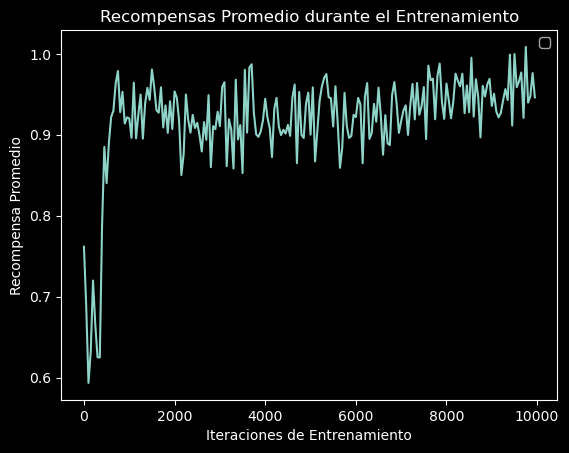

In [64]:
plot_rewards(avg_rewards, iter)

Tras implementar y entrenar nuestro agente usando CFR y MCTS en Leduc Poker, hemos realizado varias partidas contra un agente que elige acciones de manera aleatoria. Los resultados de estas partidas han sido prometedores, demostrando que nuestro agente CFR-MCTS, en promedio, mantiene un saldo positivo frente a estrategias no optimizadas. Esta constatación es un indicador inicial de la efectividad de nuestra implementación de MCTS en Leduc Poker.

> Sin embargo, es importante para futuros trabajos profundizar en la evaluación y optimización de los parámetros de MCTS, eso implica un análisis más detallado de los resultados obtenidos y la experimentación con diferentes configuraciones de parámetros, asi como la evolución de la estrategia del agente a lo largo de las iteraciones.

> Por ultimo, comparar el rendimiento de MCTS con otras técnicas de estimación de valor, como las funciones de evaluación, sería un paso importante para evaluar la efectividad de MCTS en Leduc Poker.

## Referencias

- [PettingZoo: Gym for Multi-Agent Reinforcement Learning](https://arxiv.org/abs/2009.14471)
- [Regret Circuits: Composability of Regret Minimizers](https://blog.ml.cmu.edu/2019/08/02/regret-circuits-composability-of-regret-minimizers/)
- [Khun Poker](https://en.wikipedia.org/wiki/Kuhn_poker)
- [Equilibrio de Nash](https://es.wikipedia.org/wiki/Equilibrio_de_Nash)
- [Farol (envite)](https://es.wikipedia.org/wiki/Farol_(envite))

## Descargo de Responsabilidad

### Participación de la Inteligencia Artificial en la Composición del Texto

Este documento incluye secciones cuya composición textual ha sido asistida por una Inteligencia Artificial (IA). Es importante destacar que, aunque la IA ha contribuido en la redacción de ciertas partes del texto para mejorar la claridad y estructura del mismo, los siguientes elementos son enteramente responsabilidad del alumno:

- **Desarrollo del Código**: Todo el código presente en este trabajo ha sido desarrollado y escrito por el alumno, reflejando su comprensión y aplicación práctica de los conceptos aprendidos.
- **Conclusiones**: Las conclusiones extraídas de la experimentación y análisis son fruto del criterio y razonamiento del alumno, basadas en los resultados obtenidos y las observaciones realizadas durante el desarrollo del proyecto.
- **Decisiones Metodológicas y Conceptuales**: Todas las decisiones relacionadas con la metodología, enfoque del proyecto, y la interpretación de los conceptos teóricos son producto del trabajo independiente del alumno.

### Propósito de la Asistencia de IA

El uso de la IA se ha limitado a proporcionar asistencia en la redacción para facilitar una comunicación clara y efectiva. En ningún momento, la IA ha influido en las decisiones técnicas, analíticas o conceptuales que conforman la esencia y los resultados del proyecto.